In [1]:
from __future__ import print_function, division
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%pylab notebook
import os
import sys
import numpy as np
import random
import copy
import traceback
import operator
from collections import defaultdict
from pprint import pprint
import string
from graph_tool.all import *
import scipy.stats as stats
from IPython.display import HTML
import pandas as pd
import sys
import os
lib_path = '/home/fgeigl/'
print('append', lib_path)
sys.path.append(lib_path)
import tools.mpl_tools as plt_tools
lib_path = '/home/fgeigl/navigability_of_networks'
print('append', lib_path)
sys.path.append(lib_path)
import network_matrix_tools
import powerlaw
from sklearn.preprocessing import normalize
from scipy.sparse import eye, diags
# import seaborn
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rcParams['xtick.major.pad'] *= 2
matplotlib.rcParams['ytick.major.pad'] *= 2

Populating the interactive namespace from numpy and matplotlib
append /home/fgeigl/
append /home/fgeigl/navigability_of_networks


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def find_files(base_dir, file_ending):
    res = list()
    for root, dirs, files in os.walk(base_dir):
        if not root.endswith('/'):
            root += '/'
        res.extend([root + i for i in filter(lambda x: x.endswith(file_ending), files)])
    return sorted(res)

base_dir = '/home/fgeigl/navigability_of_networks/output/opt_link_man/'
net_files = filter(lambda x: 'bow_tie' not in x, find_files(base_dir,'.gt'))
print('Networks:', net_files)
debug = False
plots_dir = base_dir + 'power_iter/'
if not os.path.isdir(plots_dir):
    os.makedirs(plots_dir)

Networks: ['/home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt', '/home/fgeigl/navigability_of_networks/output/opt_link_man/tvthek_orf.gt/tvthek_orf.gt', '/home/fgeigl/navigability_of_networks/output/opt_link_man/wiki4schools.gt/wiki4schools.gt']


In [3]:
networks = dict()
ds_name_conv = {'daserste.gt':'DEM', 'tvthek_orf.gt':'ORF', 'wiki4schools.gt':'W4S'}
for i in net_files:
    print('\tload:', i.rsplit('/', 1)[-1])
    networks[ds_name_conv[i.rsplit('/',1)[-1]]] = load_graph(i)
print(networks)
    

	load: daserste.gt
	load: tvthek_orf.gt
	load: wiki4schools.gt
{'ORF': <Graph object, directed, with 9799 vertices and 301844 edges at 0x7fcf4a9df390>, 'W4S': <Graph object, directed, with 4051 vertices and 111795 edges at 0x7fceeb88a3d0>, 'DEM': <Graph object, directed, with 70063 vertices and 3448513 edges at 0x7fcf48250110>}


<IPython.core.display.Javascript object>


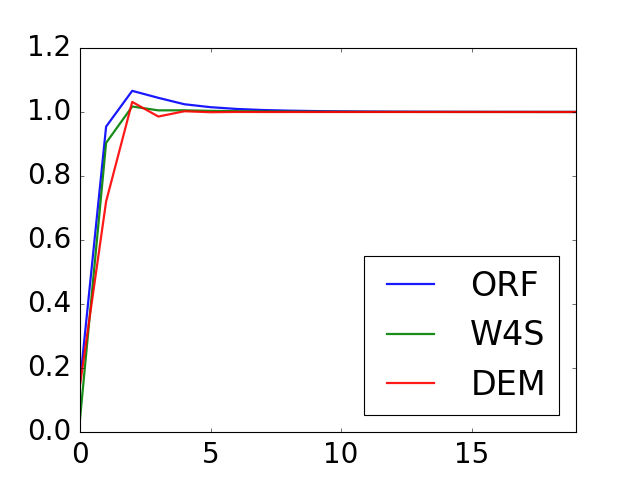

In [4]:
df = pd.DataFrame()
n_iter = 20
for net_name, net in networks.iteritems():
    A = adjacency(net)
    P = normalize(A, norm='l1', axis=0, copy=False)
    pi_vec = np.ones(P.shape[0]) / P.shape[0]
    diff = list()
    for i in range(n_iter):
        last_vec = pi_vec.copy()
        pi_vec = P.dot(pi_vec)
        norm = np.sqrt(np.power(pi_vec, 2).sum())
        pi_vec /= norm
        diff.append(norm)
    df[net_name] = diff
df.plot(lw=2, alpha=0.9)
plt.show()

<IPython.core.display.Javascript object>


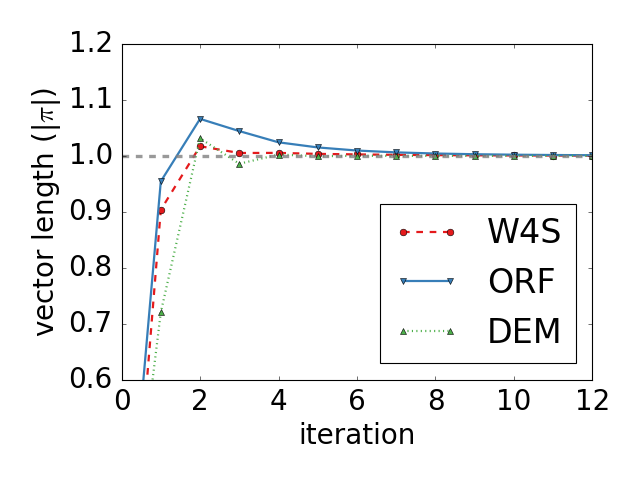

1 0.01


<IPython.core.display.Javascript object>


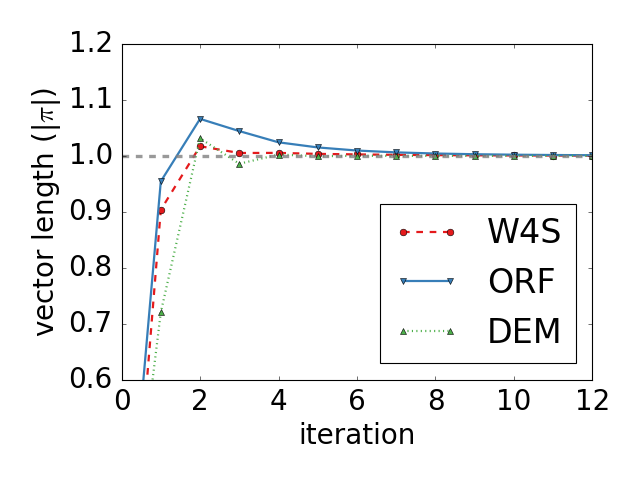

1 0.1


<IPython.core.display.Javascript object>


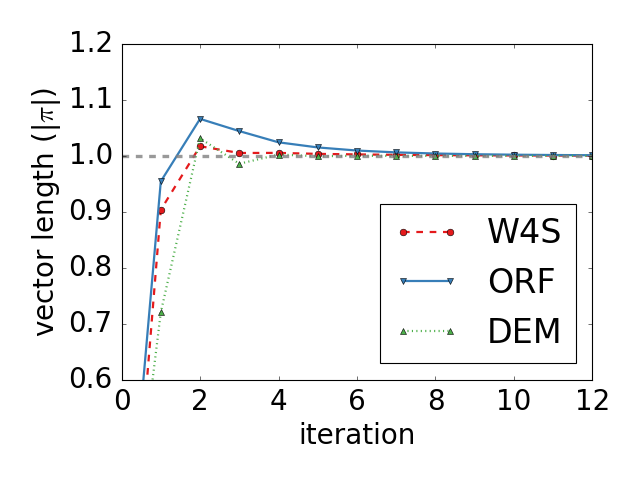

1 0.2


<IPython.core.display.Javascript object>


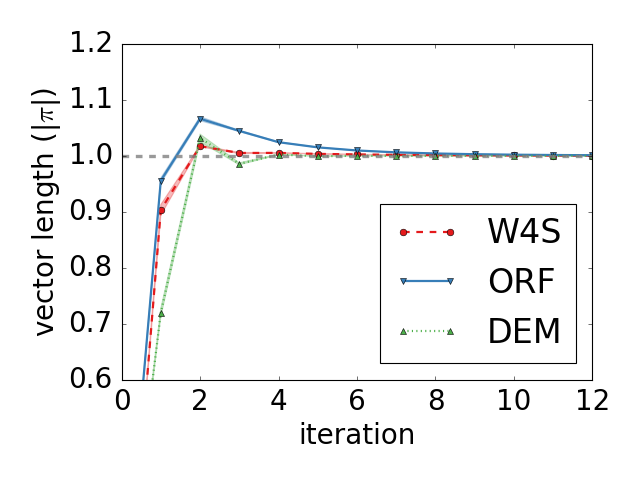

2 0.01


<IPython.core.display.Javascript object>


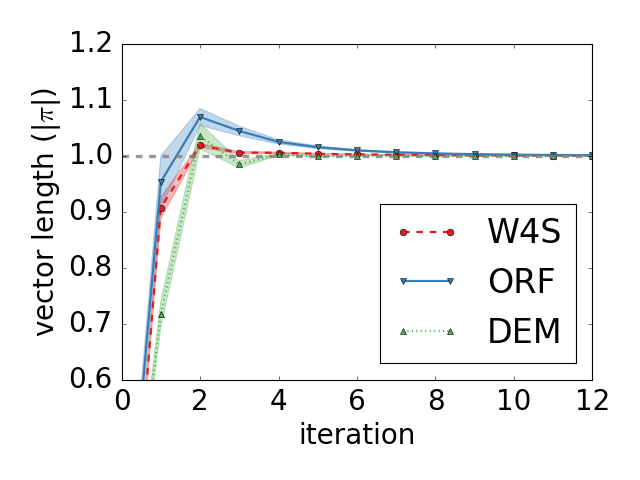

2 0.1


<IPython.core.display.Javascript object>


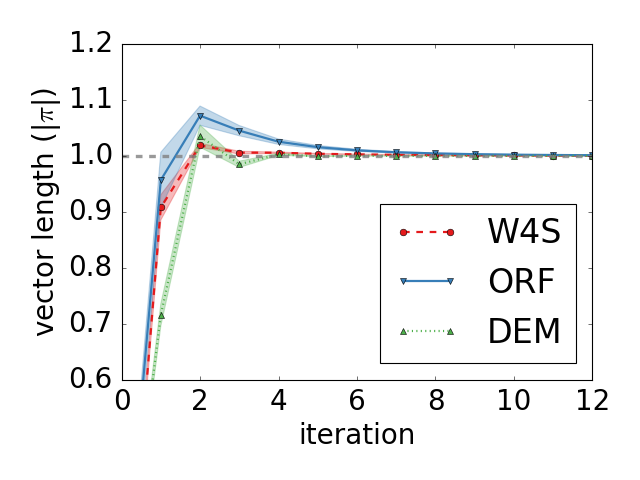

2 0.2


<IPython.core.display.Javascript object>


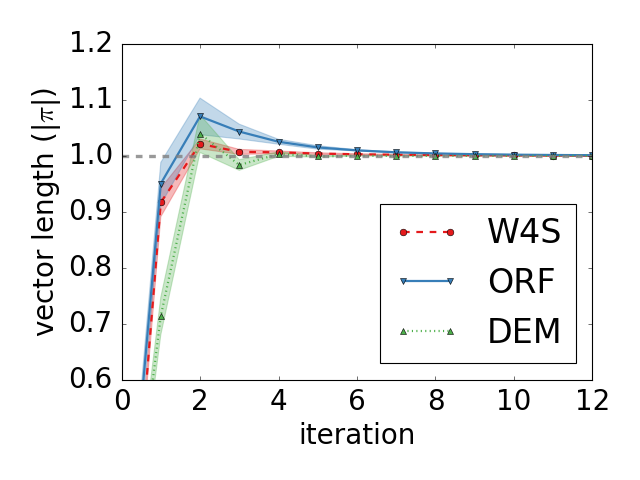

5 0.01


<IPython.core.display.Javascript object>


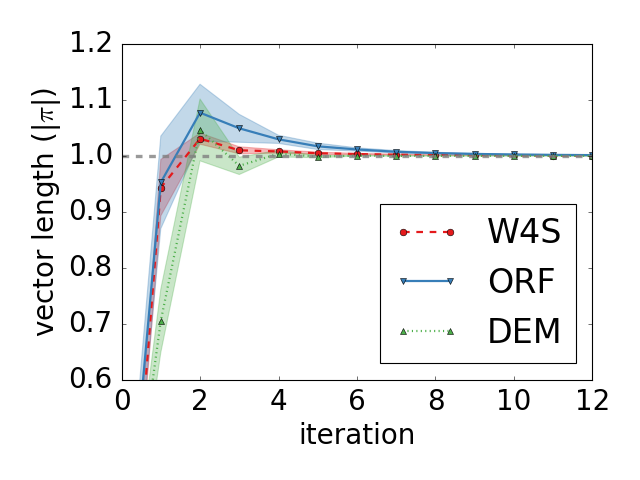

5 0.1


<IPython.core.display.Javascript object>


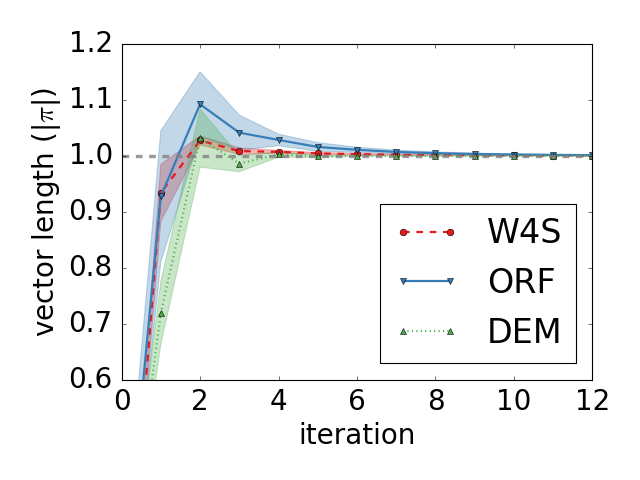

5 0.2


<IPython.core.display.Javascript object>


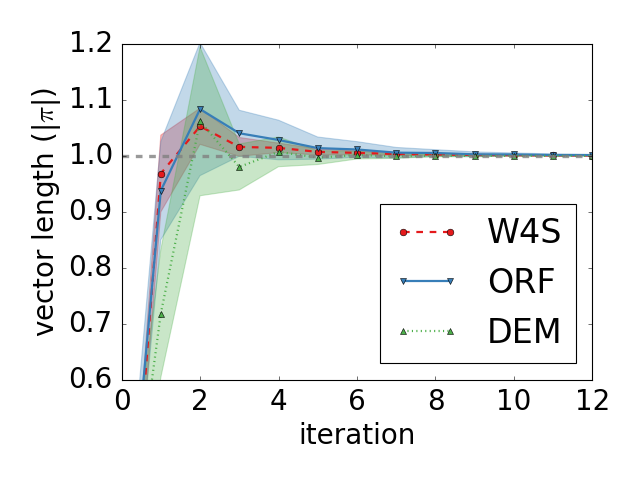

15 0.01


<IPython.core.display.Javascript object>


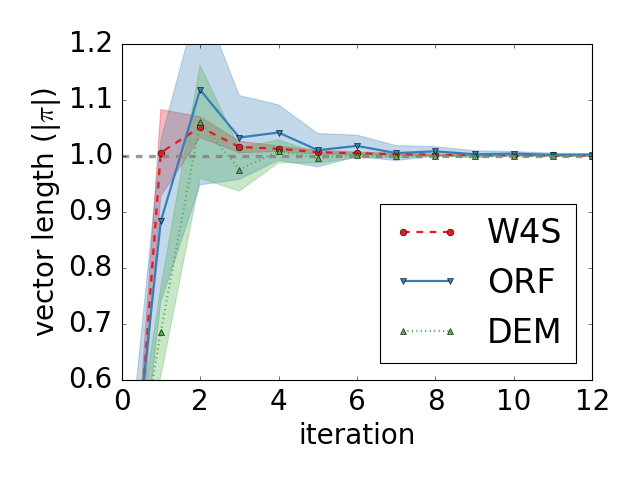

15 0.1


<IPython.core.display.Javascript object>


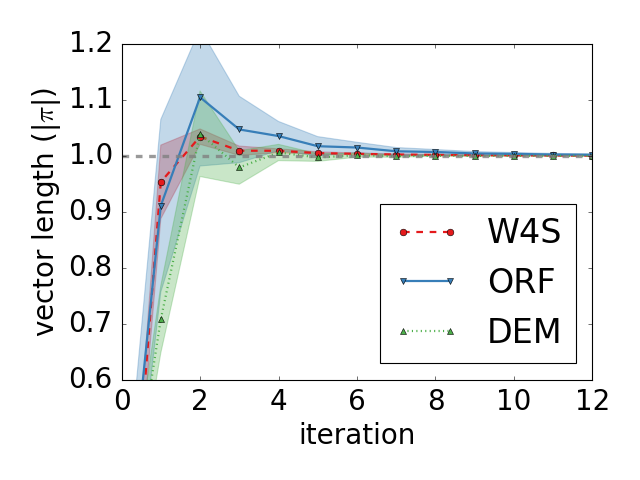

15 0.2


<IPython.core.display.Javascript object>


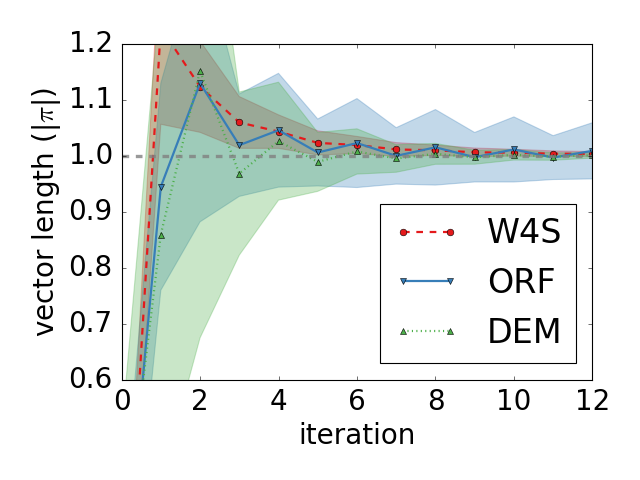

100 0.01


<IPython.core.display.Javascript object>


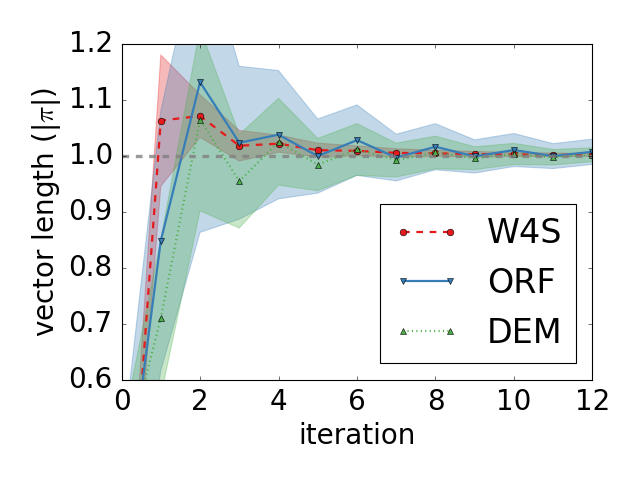

100 0.1


<IPython.core.display.Javascript object>


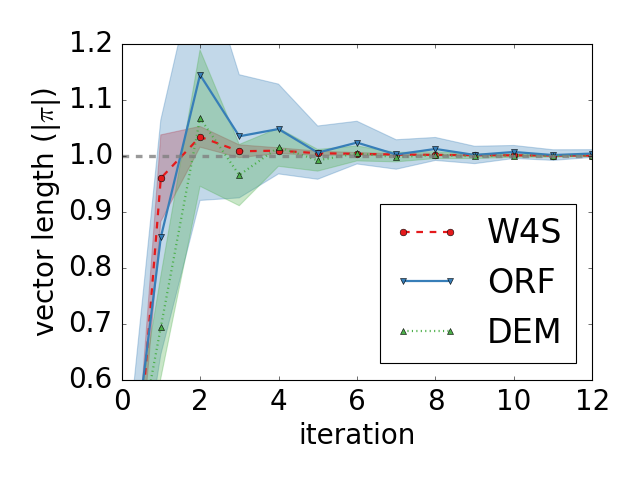

100 0.2


In [5]:
df_mean = pd.DataFrame()
df_std = pd.DataFrame()
n_iter = 20
sorting = ['W4S', 'ORF', 'DEM']
for bs in [1, 2, 5, 15, 100]:
    for phi in [0.01, 0.1, 0.2]:
        fig, ax = plt.subplots()
        print(bs, phi)
        for net_name, net in sorted(networks.iteritems(), key=lambda x: sorting.index(x[0])):
            tmp_df = pd.DataFrame()
            for n_sample in range(100 if bs > 1 else 1):
                A = adjacency(net)
                if bs > 1:
                    t_v = np.zeros(A.shape[0])
                    t_v[random.sample(range(A.shape[0]), int(np.round(phi * A.shape[0])))] = 1.
                    B = eye(A.shape[0]) + ((bs - 1) * diags(t_v, 0))
                    A = B * A
                P = normalize(A, norm='l1', axis=0, copy=False)
                pi_vec = np.ones(P.shape[0]) / P.shape[0]
                diff = list()
                for i in range(n_iter):
                    last_vec = pi_vec.copy()
                    pi_vec = P.dot(pi_vec)
                    norm = np.sqrt(np.power(pi_vec, 2).sum())
                    pi_vec /= norm
                    diff.append(norm)
                tmp_df[n_sample] = diff
            df_mean[net_name] = tmp_df.mean(axis=1)
            df_std[net_name] = tmp_df.std(axis=1)
        colors = ['#e41a1c','#377eb8','#4daf4a']
        markers = "ov^<>sp*+x"
        line_styles = ['--', '-', ':']
        ax = None
        for c, color, ls,marker in zip(df_mean.columns, colors, line_styles, markers):
            ax = df_mean[c].plot(lw=2, alpha=1, color=color, ls=ls, marker=marker, ax=ax)
        for column, color in zip(df_mean.columns, colors):
            y_top = df_mean[column] + df_std[column]
            y_bot = df_mean[column] - df_std[column]
            ax.fill_between(df_mean.index.values, y_bot.values, y_top.values, alpha=0.3, color=color)
        # plt.title('bs: '  + str(bs) + ' || phi: ' + ("%.2f" % phi))
        ax.set_ylabel(r'vector length (|$\pi$|)')
        ax.set_xlabel('iteration')
        plt.ylim([0.6, 1.2])
        plt.xlim([0., 12])
        ax.axhline(y=1., lw=3, alpha=0.8, color='gray', ls='--')
        plt.legend(loc='lower right')
        plt.tight_layout()        
        plt.show()
        # break
        plt_tools.save_n_crop(plots_dir + 'power_iter_bs_' + str(bs) + '_phi_' + ("%.2f" % phi).replace('.', '_') + '.pdf')
        # plt.savefig(plots_dir + 'power_iter_bs_' + str(bs) + '_phi_' + ("%.2f" % phi) + '.pdf')
    # break

In [ ]:
exit()